В датасете стоит задача определения воздушных рейсов, которые задержат свой вылет, что выжно для устойчивости логистических цепочек и избежания опасных ситуаций. Данные содержат информацию про самолет(количество мест, срок службы, компания владелец), погоду(общее количество осадков, количество выпавшего снега, количество снега, который выпадет за день, максимальную температуру в течение дня, максимальная скорость ветра в течение дня), информацию об аэропорте(название, широта и долгота, среднее количество вылетов в месяц)

Чтение данных и приведение категориальных признаков к числовым значениям

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


In [61]:
data = pd.read_csv('data/full_data_flightdelay.csv')
data


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,2300-2359,1,11,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489058,12,7,0,1800-1859,1,11,2,123,Hawaiian Airlines Inc.,1318,...,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489059,12,7,0,2000-2059,1,11,2,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489060,12,7,0,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21


In [62]:
df = data.copy()

In [63]:
carriers = df['CARRIER_NAME'].value_counts()
carriers = carriers.index.values.tolist()
df['CARRIER_NAME'] = df['CARRIER_NAME'].replace(carriers, range(len(carriers)))

In [64]:
deps = df['DEP_TIME_BLK'].value_counts()
deps = deps.index.values.tolist()
df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].replace(deps, range(len(deps)))

In [65]:
airport = df['DEPARTING_AIRPORT'].value_counts()
airport = airport.index.values.tolist()
df['DEPARTING_AIRPORT'] = df['DEPARTING_AIRPORT'].replace(airport, range(len(airport)))

In [66]:
prev_airport = df['PREVIOUS_AIRPORT'].value_counts()
prev_airport = prev_airport.index.values.tolist()
df['PREVIOUS_AIRPORT'] = df['PREVIOUS_AIRPORT'].replace(prev_airport, range(len(prev_airport)))

In [67]:
df.dtypes

MONTH                              int64
DAY_OF_WEEK                        int64
DEP_DEL15                          int64
DEP_TIME_BLK                       int64
DISTANCE_GROUP                     int64
SEGMENT_NUMBER                     int64
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int64
CARRIER_NAME                       int64
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int64
DEPARTING_AIRPORT                  int64
LATITUDE                         float64
LONGITUDE                        float64
PREVIOUS_AIRPORT                   int64
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [68]:
tdf = df.copy()

Оценка корреляции данных 

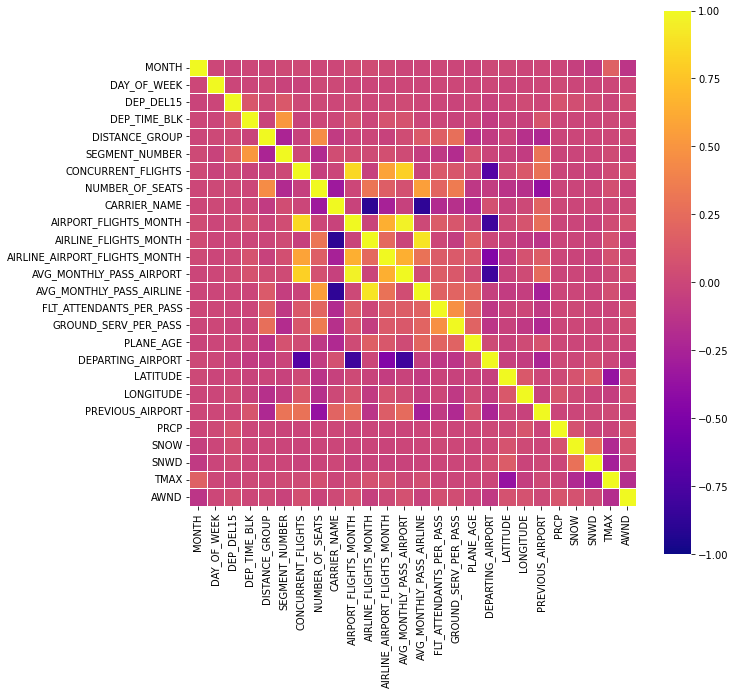

In [69]:
fig, ax = plt.subplots(figsize=(10,10))

corr_mat = df.corr()
sns.heatmap(corr_mat, square=True, cmap='plasma', linewidths=.5, ax=ax, vmin = -1, vmax = 1)
pass

In [70]:
corr_mat['DEP_DEL15']

MONTH                           -0.019049
DAY_OF_WEEK                     -0.000199
DEP_DEL15                        1.000000
DEP_TIME_BLK                     0.109707
DISTANCE_GROUP                   0.016289
SEGMENT_NUMBER                   0.117528
CONCURRENT_FLIGHTS               0.009028
NUMBER_OF_SEATS                  0.011845
CARRIER_NAME                     0.002282
AIRPORT_FLIGHTS_MONTH            0.026740
AIRLINE_FLIGHTS_MONTH            0.003528
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.013711
AVG_MONTHLY_PASS_AIRPORT         0.024383
AVG_MONTHLY_PASS_AIRLINE         0.001257
FLT_ATTENDANTS_PER_PASS         -0.002114
GROUND_SERV_PER_PASS            -0.016736
PLANE_AGE                        0.006220
DEPARTING_AIRPORT               -0.037350
LATITUDE                         0.000490
LONGITUDE                        0.027097
PREVIOUS_AIRPORT                 0.001224
PRCP                             0.080277
SNOW                             0.050156
SNWD                             0

Избавляемся от данных, зависимость от которых мала

In [71]:
df = df.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)
df

,MONTH,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
0,1,0,0,2,1,143,13056,5873,1903352,0.000099,10,-115.152,0.00,0.0,0.0,2.91
1,1,0,1,7,1,191,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
2,1,0,2,7,1,199,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
3,1,0,2,9,1,180,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
4,1,0,17,7,1,182,13056,1257,1903352,0.000125,10,-115.152,0.00,0.0,0.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,0,18,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489058,12,0,10,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489059,12,0,14,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489060,12,0,15,1,12,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21


Больше всего самолетов отменяют в июне(относительно общего числа полетов)

Text(0, 0.5, 'Departure Delays')

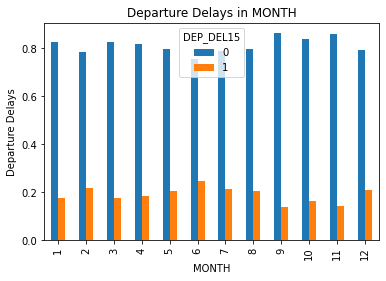

In [72]:
pd.crosstab(data.MONTH, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in MONTH')
plt.xlabel('MONTH')
plt.ylabel('Departure Delays')

Text(0, 0.5, 'Departure Delays')

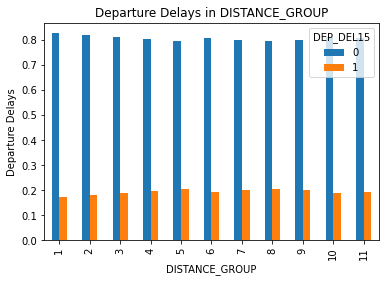

In [73]:
pd.crosstab(data.DISTANCE_GROUP, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in DISTANCE_GROUP')
plt.xlabel('DISTANCE_GROUP')
plt.ylabel('Departure Delays')

Text(0, 0.5, 'Departure Delays')

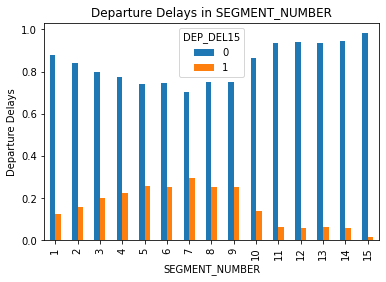

In [74]:
pd.crosstab(data.SEGMENT_NUMBER, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in SEGMENT_NUMBER')
plt.xlabel('SEGMENT_NUMBER')
plt.ylabel('Departure Delays')

Уменьшим выборку данных для более быстрого обучения

In [75]:
req = 100000
c2 = df[df['DEP_DEL15'] == 1]
c1 = df[df['DEP_DEL15'] == 0]
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df = pd.concat([df_2,df_1],axis=0)

In [76]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)

In [78]:
X_train

,MONTH,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
3242853,7,5,2,2,90,10275,1321,1297685,0.000090,19,-75.249,0.00,0.0,0.0,10.29
1487317,3,10,3,6,76,1463,120,121022,0.000094,76,-81.202,0.15,0.0,0.0,10.29
2311699,5,6,7,2,191,13575,5688,1581456,0.000149,12,-93.218,0.00,0.0,0.0,5.82
1642106,4,13,5,3,160,7011,3942,1413432,0.000177,24,-80.286,0.00,0.0,0.0,7.83
2942809,6,9,1,4,50,28904,5559,3103410,0.000099,1,-87.906,0.00,0.0,0.0,4.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553487,2,10,4,2,76,20700,2879,2907365,0.000091,2,-97.030,0.00,0.0,0.0,12.53
6187083,12,5,5,2,157,12707,5527,1581456,0.000149,12,-93.218,0.00,0.0,0.0,6.93
4367629,9,12,5,4,157,6520,788,1391212,0.000149,22,-80.152,0.07,0.0,0.0,13.20
3385069,7,13,5,4,143,11201,1342,955406,0.000099,16,-77.037,0.00,0.0,0.0,5.14


Классификация с помощью метода k-nearest neighbors

In [79]:
neighbors = np.arange(1,7)
train = []
test = []
for i,k in enumerate(neighbors):
    knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))])
    knn.fit(X_train, y_train)
    train.append(knn.score(X_train, y_train))
    test.append(knn.score(X_test, y_test))
    print(f'{k} done')

1 done
2 done
3 done
4 done
5 done
6 done


0.5902166666666666

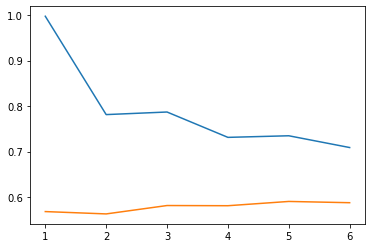

In [80]:
plt.plot(np.arange(1,7), train)
plt.plot(np.arange(1,7), test)
max(test)

In [81]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=6))])

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

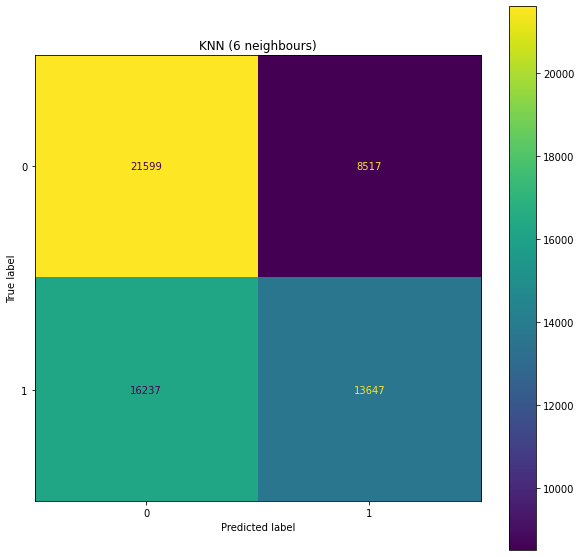

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
plot_confusion_matrix(knn, X_test,y_test, ax=ax)  
plt.show

Классификация с помощью логистической регрессии

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [84]:
predict = model.predict(X_test)
acc = accuracy_score(predict, y_test)
acc

0.4962

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

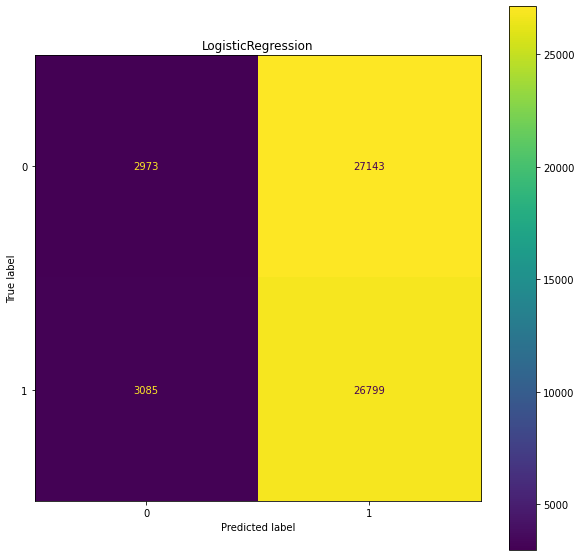

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
plot_confusion_matrix(model, X_test,y_test, ax=ax)  
plt.show

Классификация на полных данных, по наиболее каррелируемым признакам

In [86]:
X = tdf[["TMAX","PRCP","SNOW","CARRIER_NAME","SNWD","AWND","CONCURRENT_FLIGHTS","DEP_TIME_BLK","DEPARTING_AIRPORT","FLT_ATTENDANTS_PER_PASS","NUMBER_OF_SEATS"]] #"TMAX","CARRIER_NAME","CONCURRENT_FLIGHTS","FLT_ATTENDANTS_PER_PASS"
y = tdf["DEP_DEL15"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [87]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [88]:
predict = model.predict(X_test)
acc = accuracy_score(predict, y_test)
acc

0.810478859435065

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

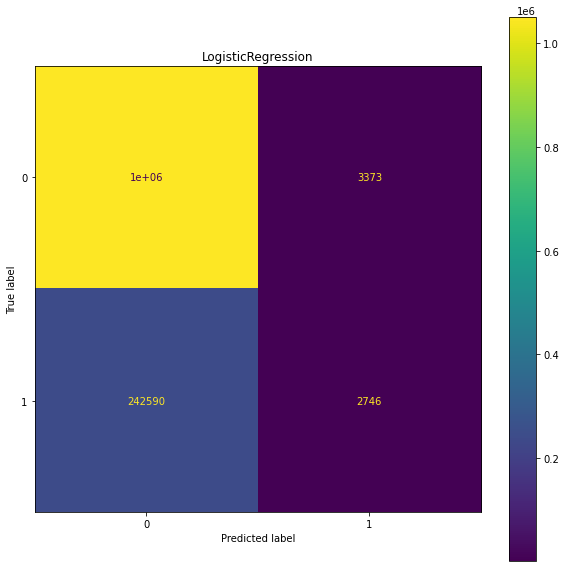

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
plot_confusion_matrix(model, X_test, y_test, ax=ax)  
plt.show

In [95]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
prediction = model.predict(X_test)
acc = accuracy_score(predict, y_test)
acc

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8127395857492566

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

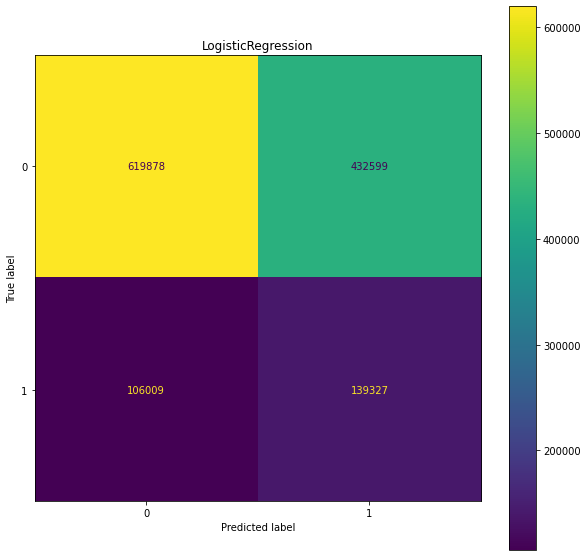

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
plot_confusion_matrix(model, X_test, y_test, ax=ax)  
plt.show

In [90]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=6))])

In [91]:
predict = knn.predict(X_test)
acc = accuracy_score(predict, y_test)
acc

0.8127395857492566

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

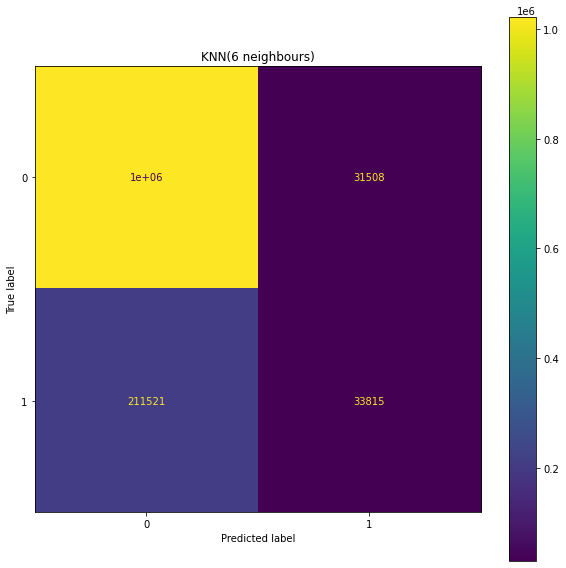

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN(6 neighbours)')
plot_confusion_matrix(knn, X_test, y_test, ax=ax)  
plt.show